In [4]:
import pandas as pd
from utils.text_tokenization import get_bert_embedding, get_bert_embedding_batch
from utils.text_clustering import get_clusters
from utils.data_visualize import visualize_clusters
from tqdm import tqdm

In [5]:
csv_path = './data/raw_scrap_data.csv'

df = pd.read_csv(csv_path)

text_list = df['title'].tolist()[:1000]

In [6]:
# embeddings = []
# for text in tqdm(text_list):
#     embedding = get_bert_embedding(text)
#     embeddings.append(embedding.squeeze().numpy())
embeddings = get_bert_embedding_batch(text_list)

100%|██████████| 32/32 [00:12<00:00,  2.60it/s]


In [7]:
clusters, embeddings_2d = get_clusters(embeddings, num_clusters=3)

c:\Users\jigne\Documents\project\reddit_tagger\env\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\jigne\Documents\project\reddit_tagger\env\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


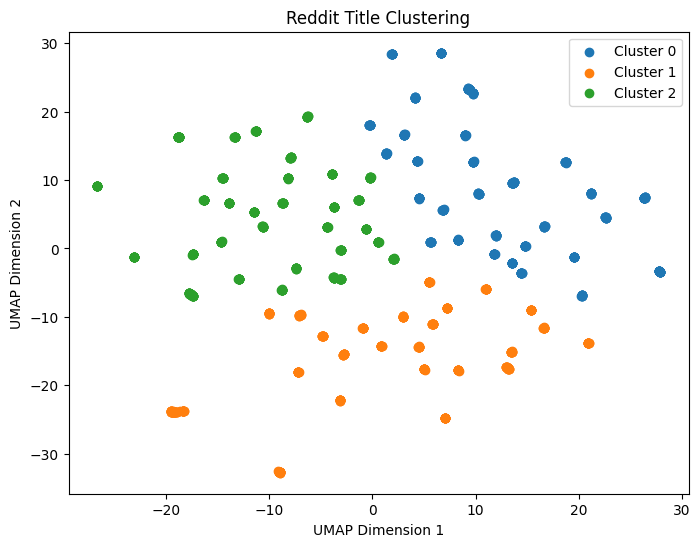

In [8]:
visualize_clusters(embeddings_2d, clusters, num_clusters=3)

In [17]:
from utils.zero_shot_classification import get_zero_shot_classification

result = []
for text, cluster in zip(text_list, clusters):
    try:
        zero_shot_cls_result = get_zero_shot_classification(text, ['positive', 'negative', 'neutral'])
        result.append({"text": text, "cluster": cluster, "zero_shot_cls_result": zero_shot_cls_result})
    except Exception as e:
        print(f"Error processing text: {text}. Error: {e}")
        result.append({"text": text, "cluster": cluster, "zero_shot_cls_result": None})

In [24]:
from sklearn.cluster import DBSCAN

# Apply DBSCAN clustering
dbscan = DBSCAN(eps=0.5, min_samples=2)  # Tune 'eps' for better separation
dbscan_clusters = dbscan.fit_predict(embeddings_2d)

In [28]:
tmp_result = []

for tmp, dbscan_result in zip(result, dbscan_clusters):
    tmp_result.append({"text": tmp['text'], "cluster": dbscan_result, "zero_shot_cls_result": tmp['zero_shot_cls_result'] })
    

In [21]:
from collections import Counter

def cluster_label_percentages(data):
    """
    Calculate the percentage distribution of labels within each cluster.

    :param data: List of dictionaries with keys ["text", "cluster", "zero_shot_cls"]
    :return: Dictionary where keys are clusters, and values are label distributions.
    """
    # Convert input data to a Pandas DataFrame
    df = pd.DataFrame(data)

    # Group by clusters and count label occurrences
    cluster_counts = df.groupby("cluster")["zero_shot_cls_result"].value_counts(normalize=True) * 100

    # Convert to dictionary format {cluster: {label: percentage, ...}, ...}
    result = {}
    for (cluster, label), percentage in cluster_counts.items():
        result.setdefault(cluster, {})[label] = round(percentage, 2)

    return result

In [29]:
cluster_label_percentages_result = cluster_label_percentages(tmp_result)
print(cluster_label_percentages_result)

{0: {'negative': 100.0}, 1: {'positive': 100.0}, 2: {'positive': 100.0}, 3: {'negative': 100.0}, 4: {'negative': 100.0}, 5: {'positive': 100.0}, 6: {'neutral': 100.0}, 7: {'positive': 100.0}, 8: {'positive': 100.0}, 9: {'positive': 100.0}, 10: {'positive': 100.0}, 11: {'positive': 100.0}, 12: {'neutral': 100.0}, 13: {'negative': 100.0}, 14: {'positive': 100.0}, 15: {'neutral': 100.0}, 16: {'positive': 100.0}, 17: {'negative': 100.0}, 18: {'positive': 100.0}, 19: {'neutral': 100.0}, 20: {'positive': 100.0}, 21: {'positive': 100.0}, 22: {'positive': 100.0}, 23: {'negative': 100.0}, 24: {'positive': 100.0}, 25: {'negative': 100.0}, 26: {'negative': 100.0}, 27: {'negative': 100.0}, 28: {'neutral': 100.0}, 29: {'positive': 100.0}, 30: {'neutral': 100.0}, 31: {'positive': 100.0}, 32: {'positive': 100.0}, 33: {'negative': 100.0}, 34: {'neutral': 100.0}, 35: {'neutral': 100.0}, 36: {'neutral': 100.0}, 37: {'negative': 100.0}, 38: {'negative': 100.0}, 39: {'neutral': 100.0}, 40: {'negative': 10

In [32]:
import pandas as pd
from collections import Counter

def assign_majority_label(data):
    """
    Assigns the majority label to each text based on its cluster.

    :param data: List of dictionaries with keys ["text", "cluster", "zero_shot_cls"]
    :return: Pandas DataFrame with an additional column "majority_label"
    """
    df = pd.DataFrame(data)

    # Find the majority label per cluster
    majority_labels = df.groupby("cluster")["zero_shot_cls_result"].agg(lambda x: Counter(x).most_common(1)[0][0])

    # Map majority labels back to the DataFrame
    df["label"] = df["cluster"].map(majority_labels)

    return df

In [35]:
df = assign_majority_label(tmp_result)
df.drop(columns=['zero_shot_cls_result', "cluster"], inplace=True)

In [36]:
df.to_csv('./data/process_data.csv', index=False)

In [49]:
import pandas as pd
from model_script.train_model import train_model_text_cls

df = pd.read_csv('./data/process_data.csv')



In [50]:
result = train_model_text_cls(df["text"].tolist(), df["label"].tolist())

NameError: name 'convert_into_bow' is not defined

In [47]:
label_mapping = {label: i for i, label in enumerate(df["label"].unique())}
df["label"] = df["label"].map(label_mapping)